In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
pi = np.pi
clight = 299792458

In [140]:
working_folder = 'case_studies/case12_10k_dyn_on_0/000000000000nmacro72000_nBin133_Idc2.50A_ThetaL10.0degree_delay0.000us_gain0.00_0.00/'
cwd = working_folder#os.path.join(home,working_folder)

#get the starting index in the folder name string that represent the substring of loading angle
i_start_thetaL = working_folder.find('ThetaL')+6
thetaL = float(working_folder[i_start_thetaL:i_start_thetaL+3])


In [141]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [142]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6
clight = 299792458

nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
Prad = tempinput['Prad'][0]
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF != 1 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_ini)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print("Qs = ",Qs)
print("R = ",R)
print("QL = ",QL)

Qs =  0.06041865756488236
R =  [228147949.43397352, 126748860.79665196]
QL =  [347257.1528675396, 347257.1528675396]


In [143]:
with open(datafile, mode='rb') as file: # b is important -> binary
    test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

In [144]:
time = np.array(test[0::n_stride])
Ibi = np.array(test[1::n_stride])
#Ibi_1 = np.array(test[2::n_stride])
Ibi2 = np.array(test[3::n_stride])

V = []
Ig = []
#U = []
Vref = []
Iref = []
for i in range(nRF):
    V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
    Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
    
    Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
    Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))


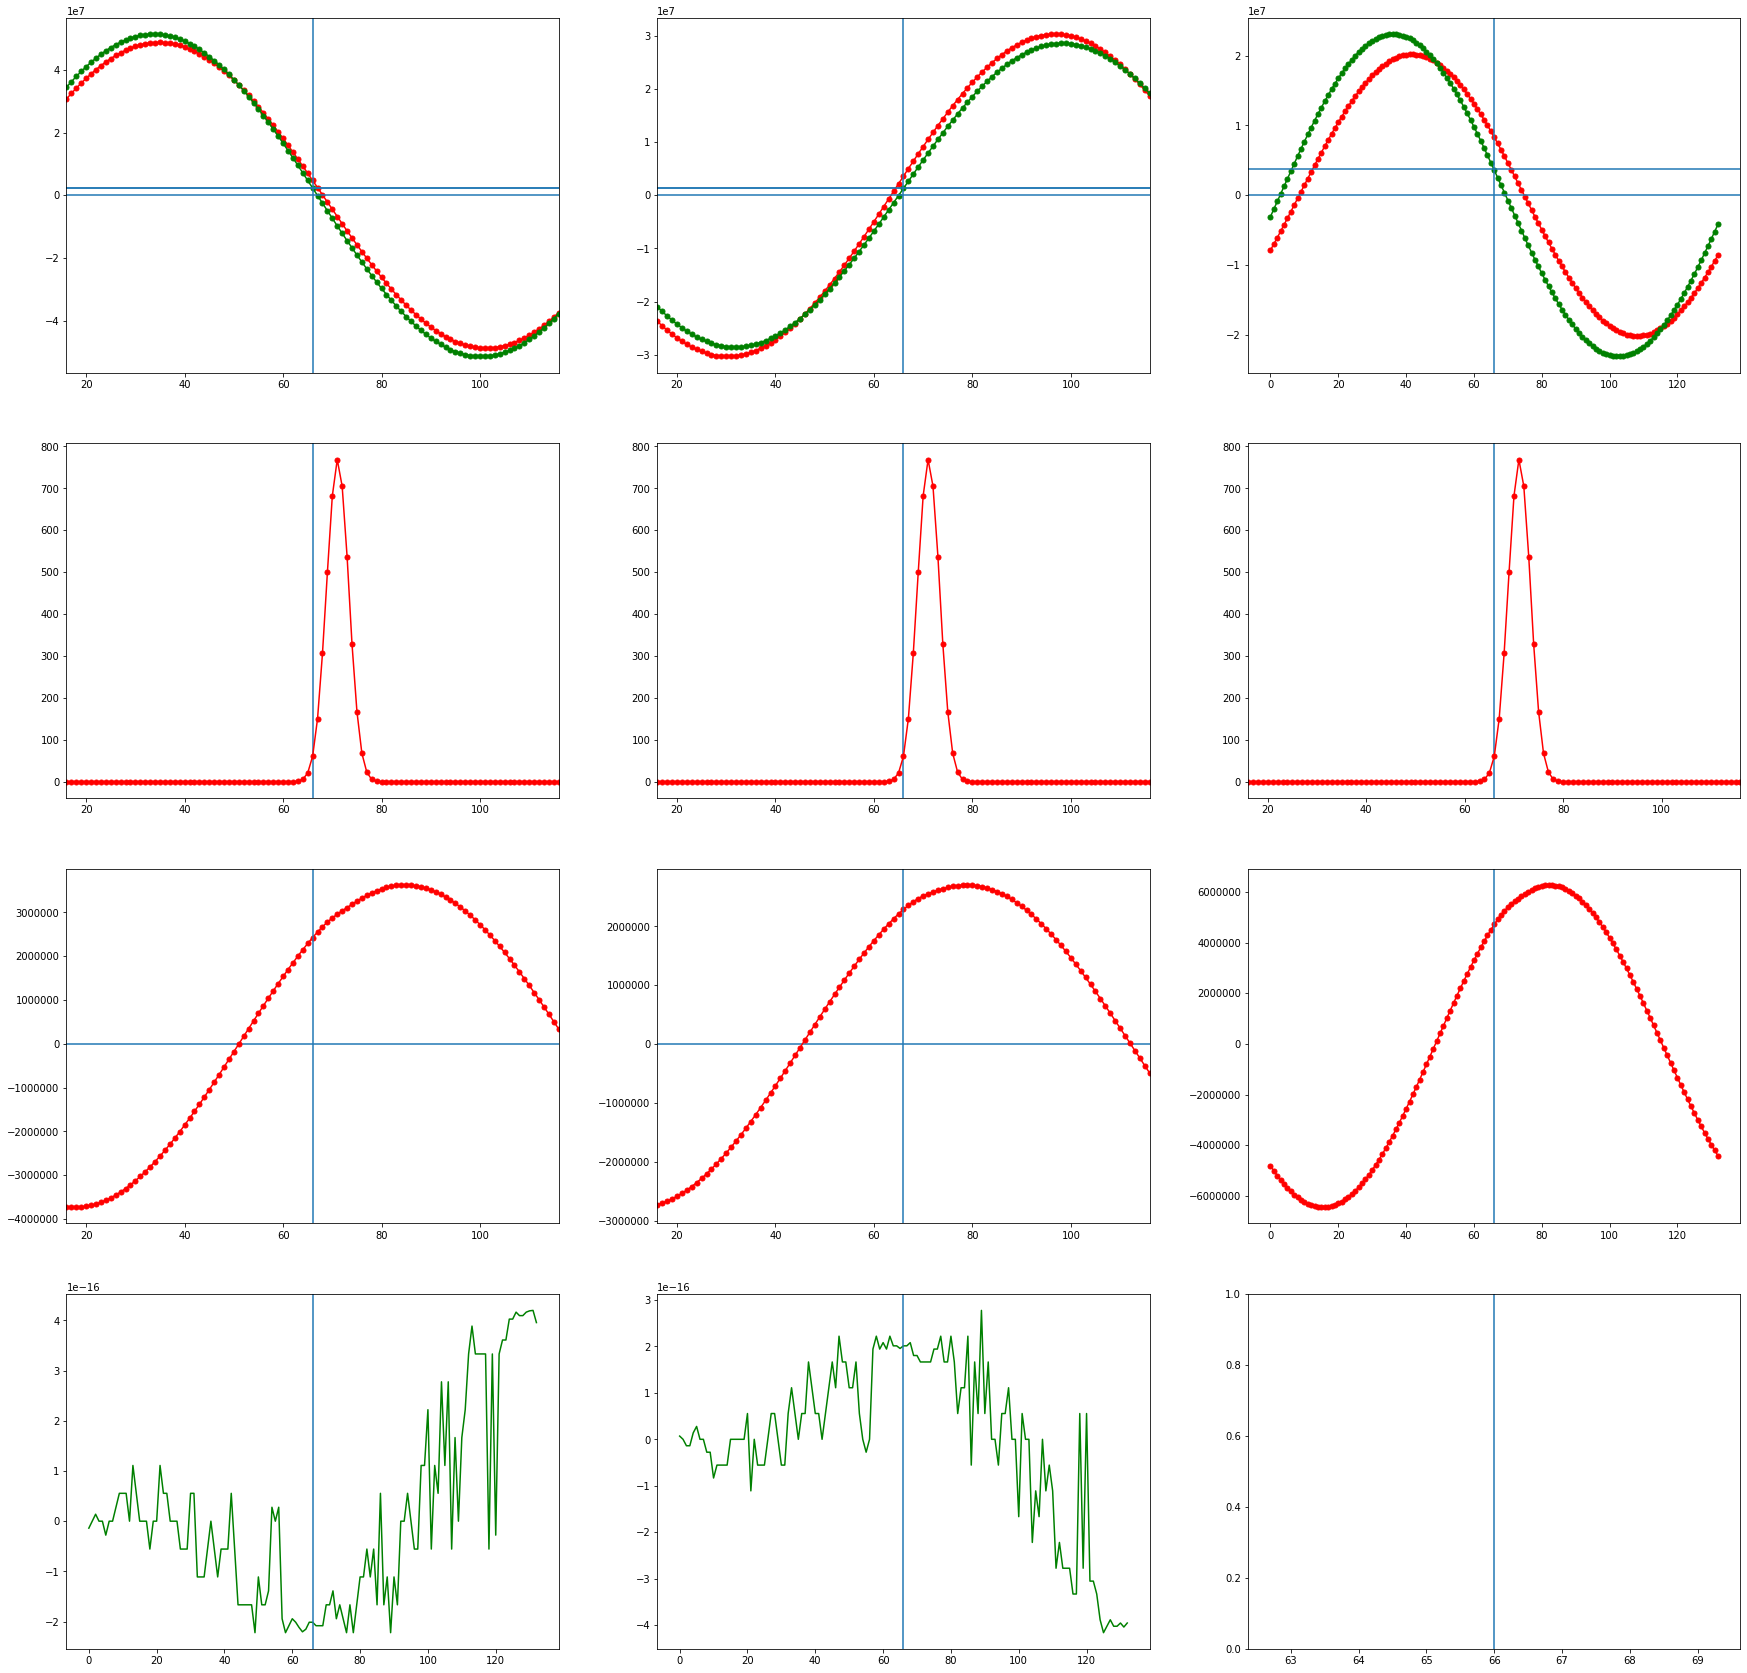

In [145]:
startTurn =int(nTurns/step-1)
startRF = 0*fill_step-24*0
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
rng3 = 50
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF+1)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][i].set_xlim([int(NpRF/2)-rng3,int(NpRF/2)+rng3])
        #axes1[0][i].set_ylim([-4e6,4e6])
        axes1[0][0].axhline(y=3.7e6/14*9)
        axes1[0][1].axhline(y=3.7e6/14*5)
        
        #axes1[0][1].axhline(y=3.7e6/14*6)
        #axes1[0][1].axhline(y=7.02e7)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[1][i].set_xlim([int(NpRF/2)-rng3,int(NpRF/2)+rng3])
        axes1[2][i].set_xlim([int(NpRF/2)-rng3,int(NpRF/2)+rng3])
        axes1[2][i].axhline(y=0)

        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].axvline(x=int(NpRF/2))
        #axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        #axes1[0][i].set_ylim([-3e6,3e6])
    Vsum = np.sum(V,0)
    Vref_sum = np.sum(Vref,0)
    
    axes1[0][nRF].plot(Vsum[rng1:rng2:step1],'r.-',ms=10)
    axes1[0][nRF].plot(Vref_sum[rng1:rng2:step1],'g.-',ms=10)
    #axes1[0][nRF].set_xlim([int(NpRF/2)-rng3,int(NpRF/2)+rng3])
    #axes1[0][nRF].set_ylim([-4e6,4e6])
    axes1[0][nRF].axhline(y=0)
    axes1[0][nRF].axhline(y=3.7e6)
    axes1[1][nRF].axvline(x=int(NpRF/2))
    axes1[0][nRF].axvline(x=int(NpRF/2))
    axes1[1][nRF].set_xlim([int(NpRF/2)-rng3,int(NpRF/2)+rng3])
    axes1[1][nRF].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
    if nBeam == 2 :
        axes1[1][nRF].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
    axes1[2][nRF].plot((Vsum-Vref_sum)[rng1:rng2:step1],'r.-',ms=10)
    axes1[2][nRF].axvline(x=int(NpRF/2))
    axes1[3][nRF].axvline(x=int(NpRF/2))
    
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.5e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2].axhline(y=0)
        axes1[2].axvline(x = int(NpRF/2))
        #axes1[2].set_ylim([-4e6,4e6])
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)
#print((V[0]-Vref[0])[rng1:rng2:step1][int(NpRF/2)]/1e6)
fn_VI = os.path.join(cwd,'VI2.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

In [146]:
print((V[i]-Vref[i])[rng1:rng2:step1][int(NpRF/2)])

2288298.3963062353


In [147]:
datafile = 'f_cav.bin'
datafile = os.path.join(cwd,datafile)
pattern = nRF*'d'
stride = len(pattern)*8
with open(datafile, mode='rb') as file: # b is important -> binary
    fileContent = file.read()
data = np.array([struct.unpack(pattern,fileContent[i*stride:(i+1)*stride]) for i in range(int(len(fileContent)/stride))]).T
frqs = []
for i in range(nRF):
    frqs.append(np.array(data[i])/2/np.pi)
V_max = []
Ig_max = []
for i in range(nRF):
    V_max.append([])
    Ig_max.append([])
    for j in range(int(len(V[i])/NpRF/h[0])-1):
        V_max[i].append(np.max(V[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
        Ig_max[i].append(np.max(Ig[i][j*NpRF*h[0]:(j+1)*NpRF*h[0]]))
Ig_max = np.array(Ig_max)
R = np.array(R)
Pg = Ig_max*Ig_max/8
for i in range(nRF):
    Pg[i] = Pg[i]*R[i]
Pg_tot = np.sum(Pg,0)
# to look at the power variation along the train
Pg_train = np.ndarray((int(nTurns/step),nRF,NpRF*h[0]))
for sample in range(int(nTurns/step)):
    for RF in range(nRF):
        Pg_train[sample][RF] = Ig[RF][sample*NpRF*h[0]:(sample+1)*NpRF*h[0]]*Ig[RF][sample*NpRF*h[0]:(sample+1)*NpRF*h[0]]/4*R[RF]
Pg_train_average = np.ndarray((int(nTurns/step),nRF,h[0]))

for sample in range(int(nTurns/step)):
    for RF in range(nRF):
        for bucket in range(h[0]):
            Pg_train_average[sample][RF][bucket] = np.sum(Pg_train[sample][RF][bucket*NpRF:(bucket+1)*NpRF])/NpRF

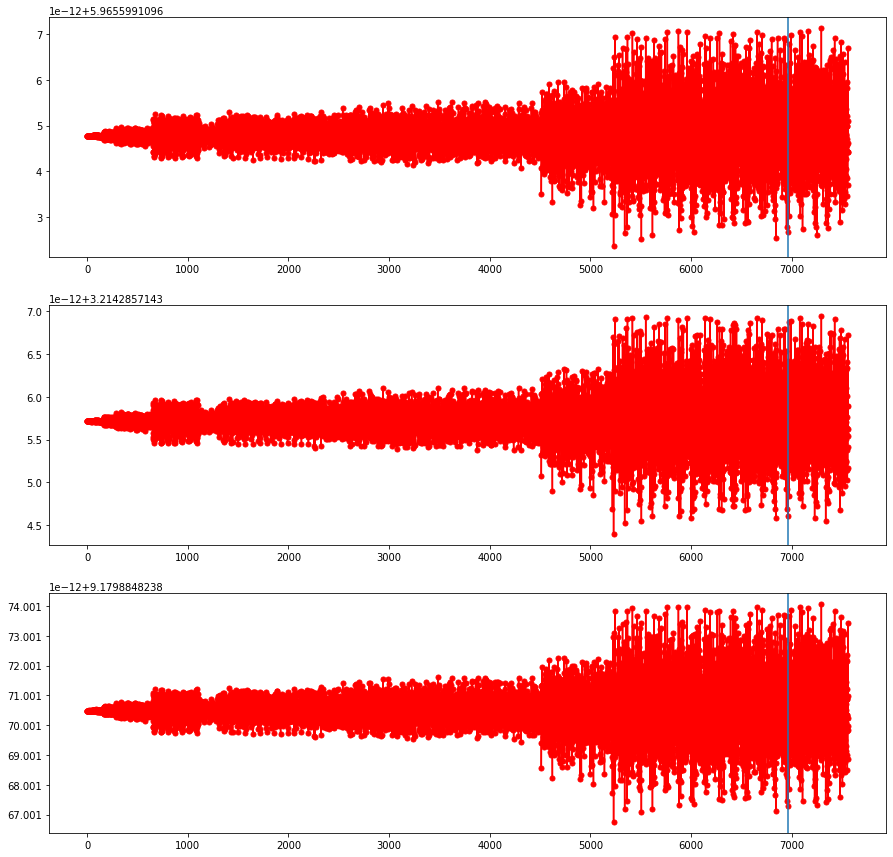

In [148]:

sample_disp = 9# the sample turn we want to see
if nRF>1:
    fig1,axes1 = plt.subplots(nRF+1,1)
    for RF in range(nRF):
        axes1[RF].plot(Pg_train_average[sample_disp][RF]/1e6,'r.-',ms=10)
        axes1[RF].axvline(x = nBunch*fill_step)
    axes1[RF+1].plot(np.sum(Pg_train_average[sample_disp]/1e6,0),'r.-',ms=10)
    axes1[RF+1].axvline(x = nBunch*fill_step)
    
else:
    fig1,axes1 = plt.subplots(1,1)
    for i in range(nRF):
        axes1.plot(Pg_train_average[sample_disp][RF],'rx-',ms=10)
        axes1.axvline(x = nBunch*fill_step)
fig1.set_figheight(15)
fig1.set_figwidth(15)
fn_VI = os.path.join(cwd,'Pg.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()

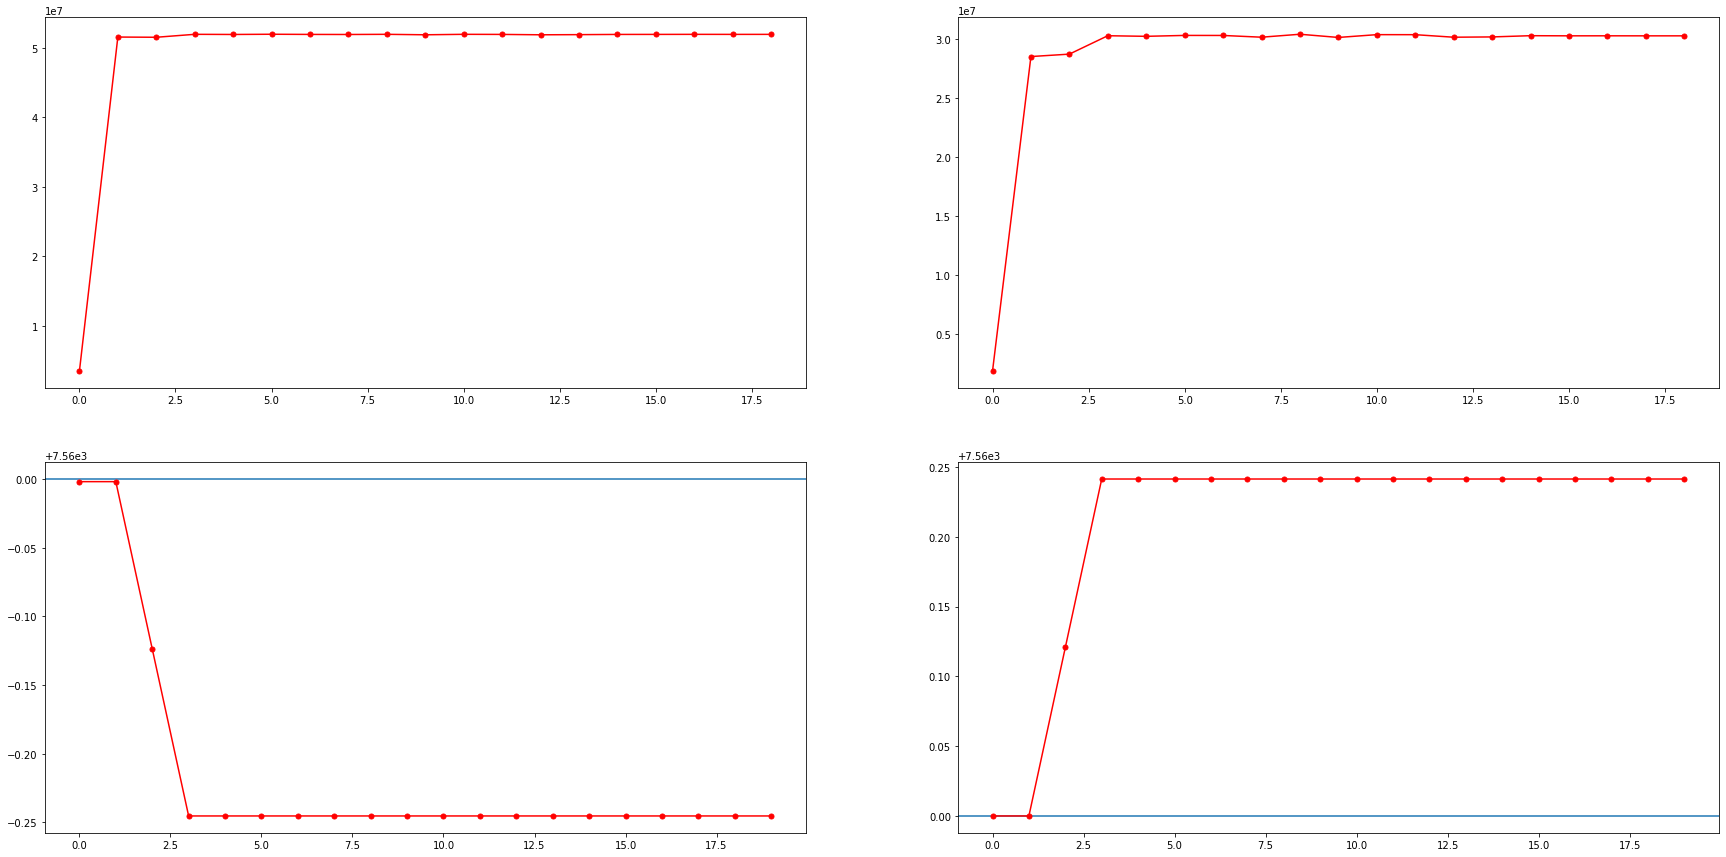

In [149]:
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
if nRF>1:
    fig1,axes1 = plt.subplots(2,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V_max[i][start:end],'r.-',ms=10)
        #axes1[0][i].set_yscale('log')
        axes1[1][i].axhline(y = h[i])
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])+1)
        #axes1[1][i].axhline(y = omegarf[i]/(omegarf[0]/h[0])-1)
        #axes1[2][i].plot(Ig_max[i][start:end],'r.-',ms=10)
        axes1[1][i].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)        
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V_max[i][start:end],'r.-',ms=10)
        axes1[1].plot(frqs[i][start:end]/(omegarf[0]/h[0]/2/np.pi),'r.-',ms=10)   
        #axes1[1].axhline(y = omegarf[i]/(omegarf[0]/h[0]))
        
fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'process.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [150]:
Pbeam = "{0:.2f}".format(Prad/1e6)
Pg_expected = "{0:.2f}".format(Prad*(9/14/np.cos(thetaL/180*pi)**2+5/14)/1e6)
Pg_max_sim = "{0:.2f}".format(Pg_tot[-1]/1e6)

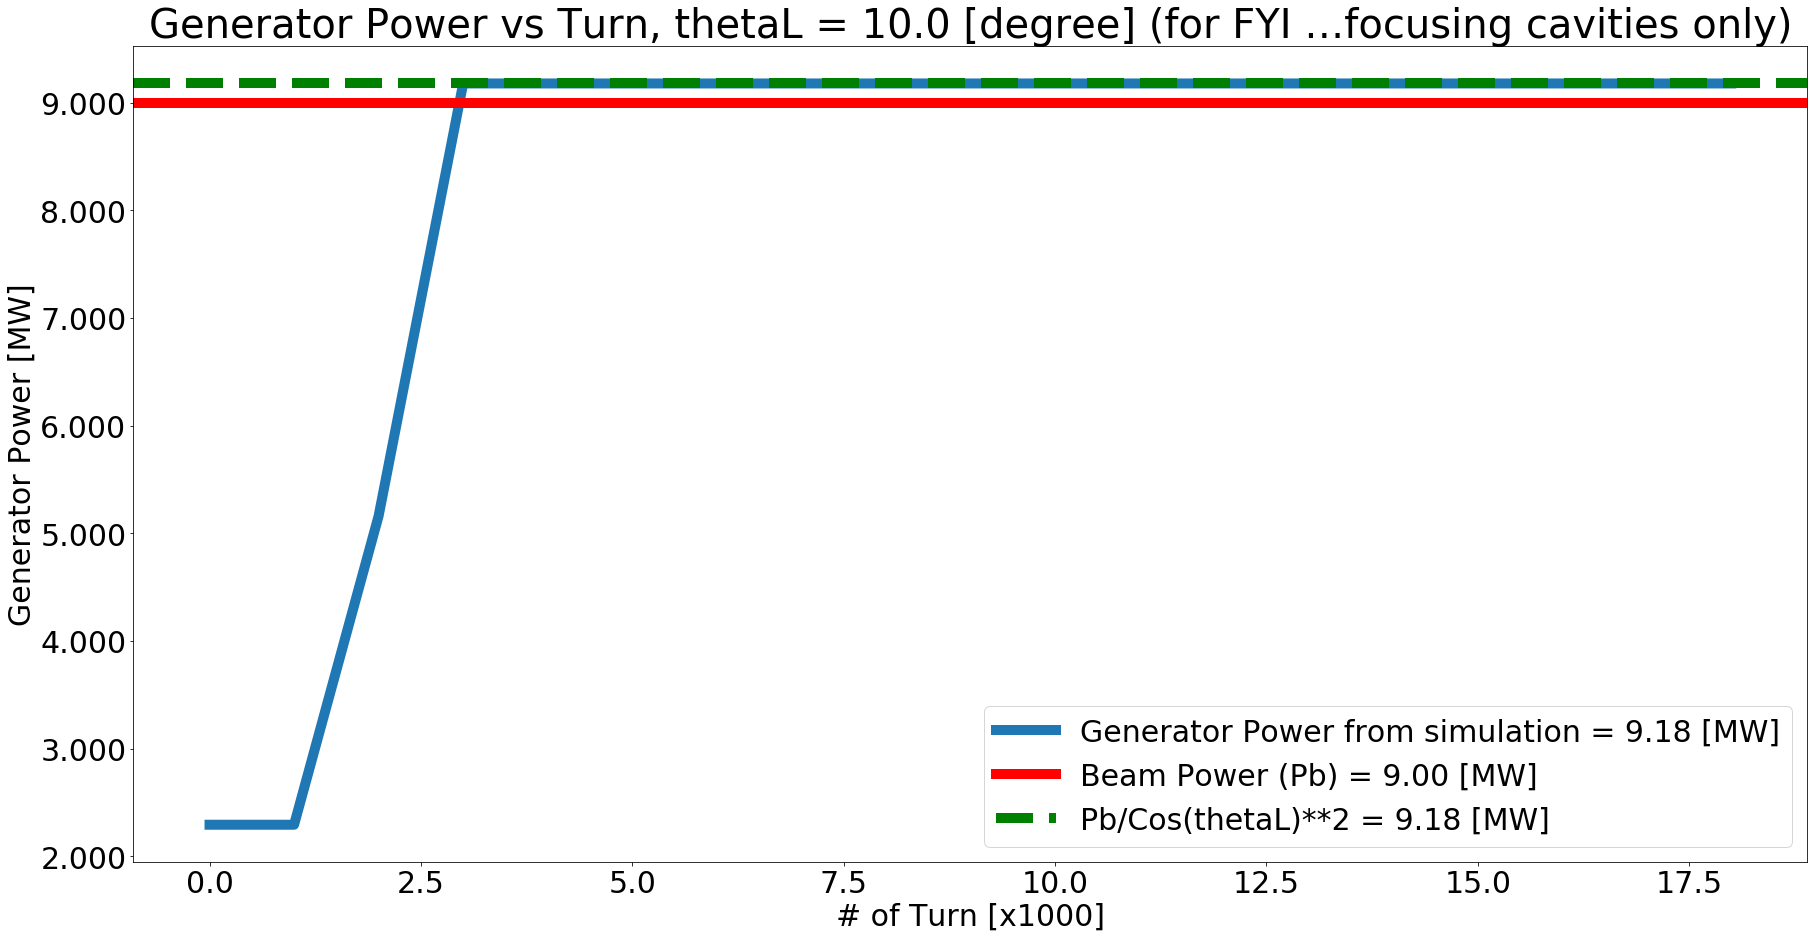

In [151]:
# plot the Power
start = 0 # this number times n_per_step gives real turn number 
end = int(nTurns/step)
fig1,axes1 = plt.subplots(1,1)
axes1.plot(Pg_tot/1e6, linewidth=10)
axes1.axhline(y = Prad/1e6,linewidth=10,color='r')
axes1.axhline(y = Prad/1e6*(9/14/np.cos(thetaL/180*pi)**2+5/14),linewidth=10,color='g', linestyle='--')

axes1.tick_params(labelsize=50)
axes1.set_ylabel("Generator Power [MW]",fontsize=30)
axes1.set_xlabel("# of Turn [x"+str(step)+"]",fontsize=30)
axes1.set_title("Generator Power vs Turn, thetaL = "+str(thetaL)+" [degree] (for FYI …focusing cavities only)",fontsize=40)
axes1.legend(["Generator Power from simulation = "+Pg_max_sim+" [MW]","Beam Power (Pb) = "+Pbeam+" [MW]", "Pb/Cos(thetaL)**2 = "+Pg_expected+" [MW]"],prop={'size': 30})
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'Pg.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

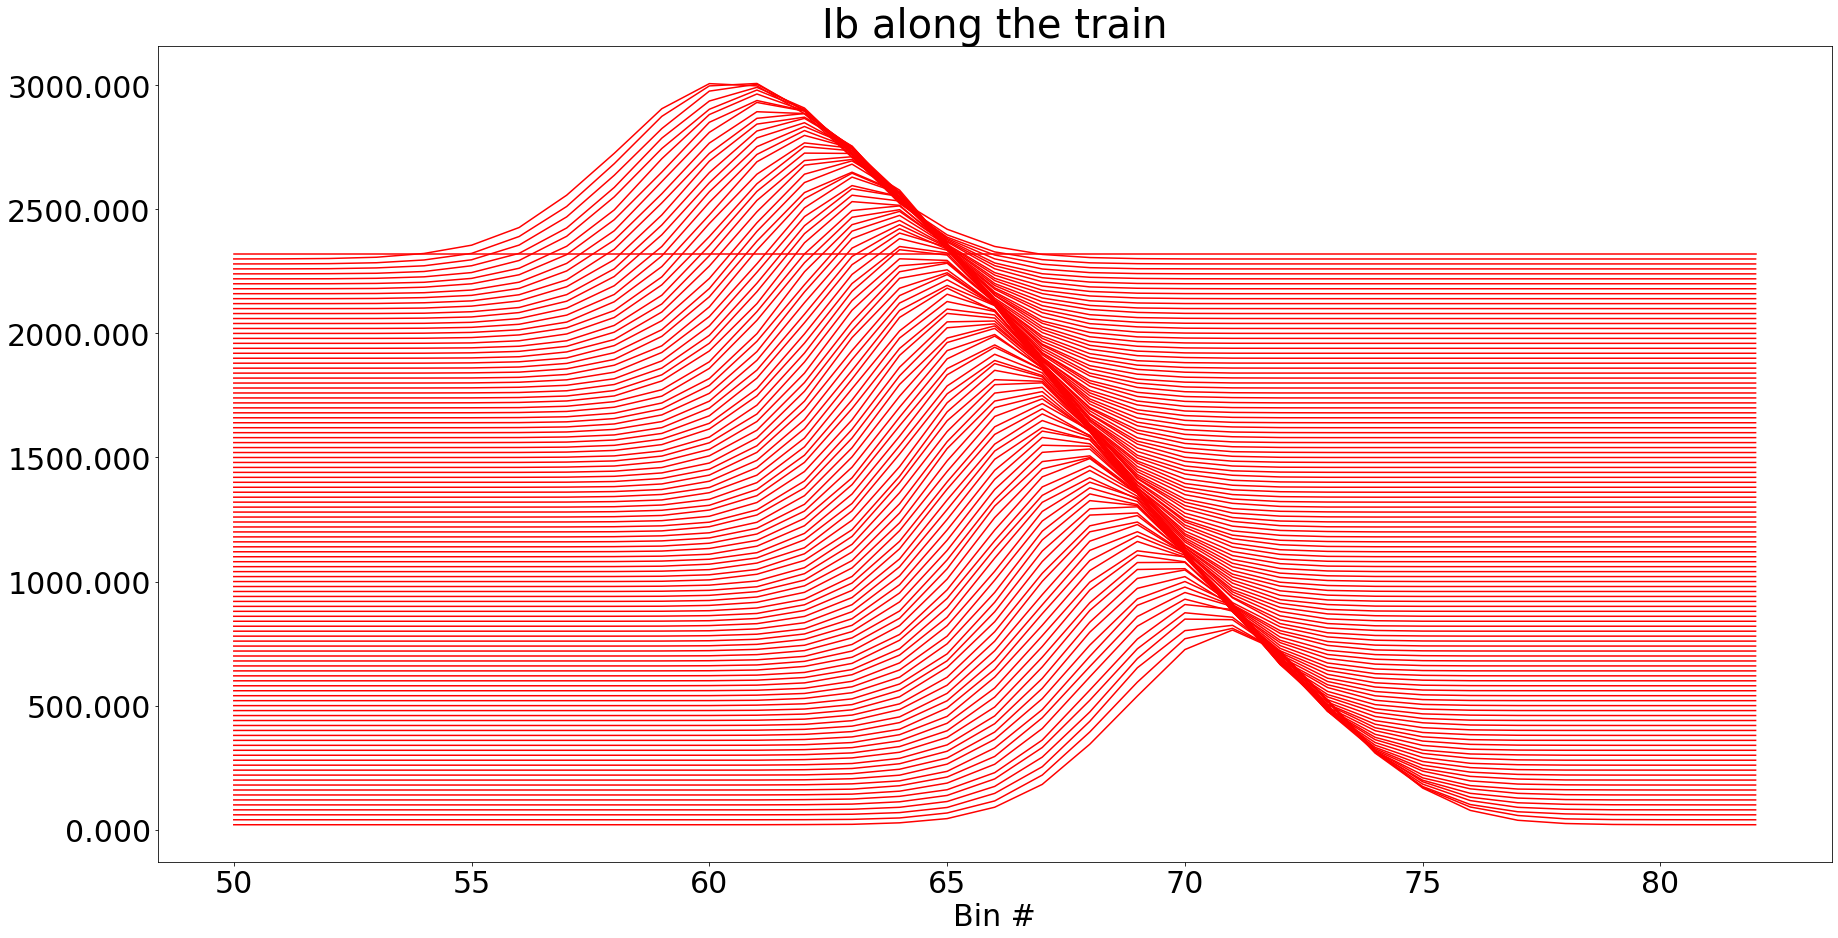

In [153]:
# range plot
turn_disp = 19
fig1,axes1 = plt.subplots(1,1)
nBunch_disp = int(nBunch/5)
bunch_disp_step = int(nBunch/nBunch_disp)
rng3 = 50

for bunch in range(nBunch_disp):
    rng1 = turn_disp*h[0]*NpRF+(nBunch_disp-bunch)*bunch_disp_step*NpRF*fill_step
    rng2 = rng1+NpRF
    bins = np.array([rng3+i for i in range(NpRF-rng3*2)])
    axes1.plot(bins,Ibi[rng1+rng3:rng2-rng3]+(nBunch_disp-bunch)*20,'r-')

axes1.tick_params(labelsize=50)
axes1.set_xlabel("Bin #",fontsize=30)
axes1.set_title("Ib along the train",fontsize=40)
axes1.tick_params(labelsize=30)
y_labels = axes1.get_yticks()
axes1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))

fig1.set_figheight(15)
fig1.set_figwidth(30)

fn_proc = os.path.join(cwd,'range_plot.jpg')
plt.savefig(fn_proc,bbox_inches='tight')
plt.show()

In [ ]:
Prad/np.cos(28/180*pi)**2

In [ ]:
np.arccos(3.7e6/14/5.8e6)/pi*180

In [ ]:
NC =14
NF = 7
ND = NC-NF

Vs = 3.7e6/NC
Vq = np.sqrt((23.7e6/NC)**2-Vs**2)
V0 = np.sqrt(Vs**2+Vq**2)
PhiPhasor0 = np.arctan(Vq/Vs)


#Vsnew = Vs
#Vqnew = Vq*NC/(NF-ND)
#V0new = np.sqrt(Vsnew**2+Vqnew**2)

VF = 3.4e6
VD = 0.1e6

VF = VF*NF
VD = VD*ND
V0 = V0*NC
PhiPhasor1 = PhiPhasor0+np.arccos((VF**2+V0**2-VD**2)/(2*VF*V0))
print("New Phasor angle : ",PhiPhasor1/pi*180)

In [ ]:
(VF**2+V0**2-VD**2)/(2*VF*V0)

In [ ]:
(VF**2+V0**2)/(2*VF*V0)

In [ ]:
PhiPhasor0/pi*180

In [ ]:
print(Vs,Vq,np.sqrt(Vs**2+Vq**2))

In [33]:
a = np.array([1])

In [36]:
a[0]

1